In [1]:
import functools

import diffrax
import equinox
import jax
import optax
import scipy.stats

jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")
import jax.numpy as jnp
import numpy as np
from matplotlib.figure import Figure
from tqdm.notebook import trange

%matplotlib inline

# Simulate stochastic Lorenz system
Why not a real-world problem? Because real-world filtering problems have a survivorship bias towards being easy for EKF and UKF filtering. We're taking on a difficult problem! The stochastic Lorenz system, simulated with a sufficiently long time step:
1. Has a large process noise (so that our filter will have a large $Q$ which means high gain)
2. Is very nonlinear (the discretization time step is commensurate with a period of one of the Lorenz system attractors)
3. Did I say chaotic?
4. Motivates neural modeling because the process noise interacts with nonlinear dynamics, so the ensemble-averaged stochastic Lorenz system doesn't have a clean ODE discretization (e.g. Runge Kutta)
5. Technically motivated by weather forecasting
   

In [2]:
@equinox.filter_jit
def F_true(
    x, key, σ=2, T=0.05, dt=1e-2, solver_args=dict(), tol=None, return_sol=False
):
    # Lorenz parameters
    sigma = 10.0
    rho = 28.0
    beta = 8 / 3

    # Drift function f(t, y)
    def drift(t, y, _args):
        x, y_, z = y
        dx = sigma * (y_ - x)
        dy = x * (rho - z) - y_
        dz = x * y_ - beta * z
        return jnp.array([dx, dy, dz])

    # Diffusion function g(t, y)
    def diffusion(t, y, _args):
        return jnp.eye(3) * σ

    # SDE solver
    solver = diffrax.ShARK()

    # Solve
    bm = diffrax.VirtualBrownianTree(
        t0=0,
        t1=T,
        tol=(tol or dt / 2),
        shape=(3,),
        key=key,
        levy_area=diffrax.SpaceTimeLevyArea,
    )
    # Set up the SDE
    sde = diffrax.MultiTerm(diffrax.ODETerm(drift), diffrax.ControlTerm(diffusion, bm))
    # Solve the SDE
    sol = diffrax.diffeqsolve(
        sde, solver=solver, t0=0, t1=T, dt0=dt, y0=x, max_steps=10000, **solver_args
    )
    if return_sol:
        return sol
    return sol.ys

In [3]:
# analytic is the clear winner
# lorenz_args = dict(σ=2.0, T=0.4, dt=1e-2)
# fair contest
lorenz_args = dict(σ=2.0, T=0.3, dt=1e-2)
# let's try to make UKF look good
# lorenz_args = dict(σ=2.0, T=0.25, dt=1e-2)

In [4]:
F_true_train_and_test = jax.jit(jax.vmap(functools.partial(F_true, **lorenz_args)))

In [6]:
N = 10000

keys = jax.random.split(jax.random.PRNGKey(3), (N, 2))
x_train_and_test = np.zeros((N, 2, 3))
x_train_and_test[0, :, :] = [-8.0, 4.0, 27.0]
for i in trange(1, N):
    x_train_and_test[i, :, :] = F_true_train_and_test(
        x_train_and_test[i - 1, :], keys[i - 1, :]
    ).squeeze()

  0%|          | 0/9999 [00:00<?, ?it/s]

In [7]:
x_train = x_train_and_test[:, 0, :]
x_test = x_train_and_test[:, 1, :]

In [8]:
plot_steps = 20
T_long = plot_steps * lorenz_args["T"]
times = np.linspace(0, T_long, 1000)
x_long = F_true(
    x_train[0],
    keys[0, 0],
    σ=lorenz_args["σ"],
    T=T_long,
    dt=lorenz_args["dt"],
    solver_args=dict(saveat=diffrax.SaveAt(ts=times)),
)

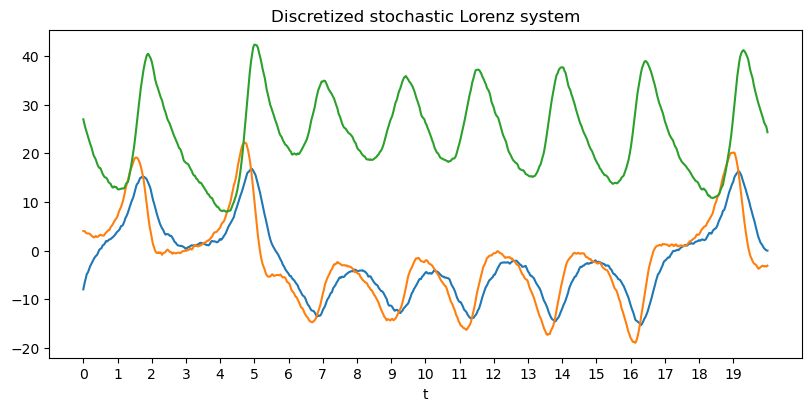

In [9]:
fig = Figure(figsize=(8, 4), dpi=100, constrained_layout=1)
ax = fig.gca()
ax.plot(times / lorenz_args["T"], x_long)
ax.set_xticks(np.arange(plot_steps))
ax.set_title("Discretized stochastic Lorenz system")
ax.set_xlabel("t")
fig

Preview train and test trajectories (which start from the same initial conditions but have independent process noise)

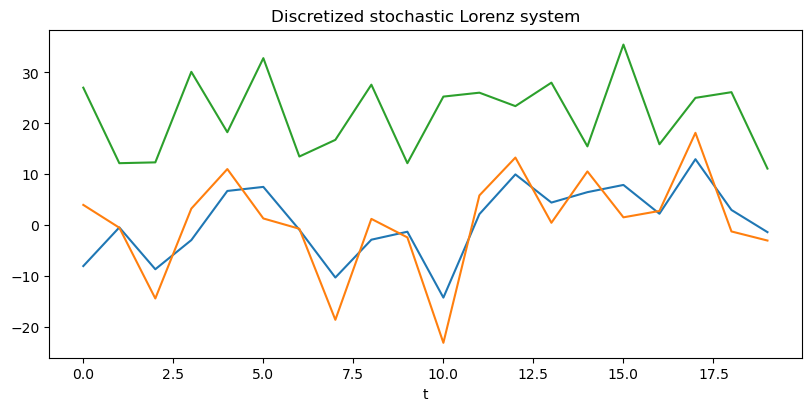

In [10]:
fig = Figure(figsize=(8, 4), dpi=100, constrained_layout=1)
ax = fig.gca()
ax.plot(x_train[:20])
# ax.plot(x_test[:100])
ax.set_title("Discretized stochastic Lorenz system")
ax.set_xlabel("t")
fig

# Learn a deep neural approximation to F

In [11]:
import os
import sys

import equinox

lib_path = os.path.join(os.path.curdir, "src")
sys.path.insert(0, lib_path)
import importlib

import kalman_diagnostics
import neural_kalman
import normal
import probit_network
import random_matrix
import unscented

importlib.reload(neural_kalman)
importlib.reload(kalman_diagnostics)
importlib.reload(normal)


importlib.reload(unscented)
importlib.reload(random_matrix)
importlib.reload(probit_network)
from normal import Normal
from probit_network import ProbitLinear, ProbitLinearNetwork
from random_matrix import RandomGaussian, RandomOrthogonalProjection, ZeroMatrix

Network architecture

In [12]:
n_x = 3
n_hidden = 100
# TODO why does calling this network break on GPU
network = ProbitLinearNetwork(
    ProbitLinear.create_probit(
        in_size=n_x,
        out_size=n_hidden,
        key=jax.random.PRNGKey(1),
        A=RandomOrthogonalProjection(),
        b=RandomOrthogonalProjection(),
    ),
    ProbitLinear.create_residual(
        in_size=n_hidden,
        out_size=n_hidden,
        key=jax.random.PRNGKey(2),
        A=RandomOrthogonalProjection(),
        b=RandomOrthogonalProjection(),
    ),
    ProbitLinear.create_residual(
        in_size=n_hidden,
        out_size=n_hidden,
        key=jax.random.PRNGKey(3),
        A=RandomOrthogonalProjection(),
        b=RandomOrthogonalProjection(),
    ),
    ProbitLinear.create_linear(
        in_size=n_hidden,
        out_size=n_x,
        C=RandomOrthogonalProjection(),
        d=RandomOrthogonalProjection(),
    ),
)

Profile likelihood loss

In [13]:
@equinox.filter_jit
def get_loss(model, x_time_series):
    pred_x = jax.vmap(model)(x_time_series[:-1])
    actual_x = x_time_series[1:]

    residual = pred_x - actual_x
    Q = jax.vmap(jnp.outer)(residual, residual).mean(0)
    return jnp.linalg.slogdet(Q)[1], Q


loss_value_and_grad = equinox.filter_value_and_grad(get_loss, has_aux=True)

AdamW optimizer with lightly hand-tuned training hyperparameters

In [14]:
@equinox.filter_jit
def step(model, x, opt_state):
    (loss, Q), grads = loss_value_and_grad(model, x)
    updates, opt_state = opt.update(grads, opt_state, params=model)
    model = equinox.apply_updates(model, updates)
    return loss, Q, model, opt_state

In [15]:
loss_history = []

In [16]:
opt = optax.adamw(learning_rate=1e-3, b1=0.9, b2=0.99)
opt_state = opt.init(network)

In [17]:
pbar = trange(1000)
# optional GPU acceleration (not much faster but relieves CPU workload)
with jax.default_device(jax.devices("cpu")[0]):
    for i in pbar:
        loss, Q, network, opt_state = step(network, x_train, opt_state)
        if i % 10 == 0:
            test_loss, test_Q = get_loss(network, x_test)
            loss_history.append((loss, test_loss))
            pbar.set_postfix(
                {
                    "nll": f"{loss:.6f}, {test_loss:.6f}",
                    "rmse": f"{Q.trace()**0.5 :.6f}, {test_Q.trace()**0.5 :.6f}",
                }
            )

  0%|          | 0/1000 [00:00<?, ?it/s]

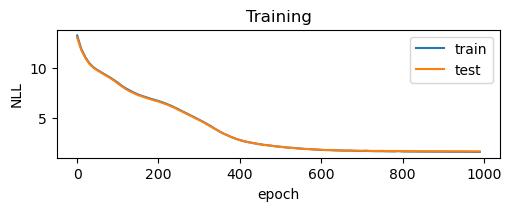

In [18]:
fig = Figure(figsize=(5, 2), constrained_layout=1)
ax = fig.gca()
ax.plot(np.arange(len(loss_history)) * 10, loss_history, label=["train", "test"])
ax.legend()
ax.set_title("Training")
ax.set_ylabel("NLL")
ax.set_xlabel("epoch")
# ax.set_yscale("log")
fig

In [19]:
print(np.linalg.eigvalsh(Q))

[0.34043227 3.07112404 4.92007464]


Compare training residuals to test residuals

In [20]:
residual = jax.vmap(network)(x_test[:-1]) - x_test[1:]
Q_empirical = jax.vmap(jnp.outer)(residual, residual).mean(axis=0)
print("residual eigenvalues", np.linalg.eigvalsh(Q_empirical))

residual eigenvalues [0.36679384 3.06991272 4.86291696]


Predict a sample trajectory

In [21]:
x_pred = np.zeros((N, 3))
x_pred[0] = x_test[0]
for i in trange(1, N):
    x_pred[i, :] = network(x_pred[i - 1, :])

  0%|          | 0/9999 [00:00<?, ?it/s]

Vibe check: preview the tail of the trajectory (the end is more sensitive to degeneracy than the beginning)

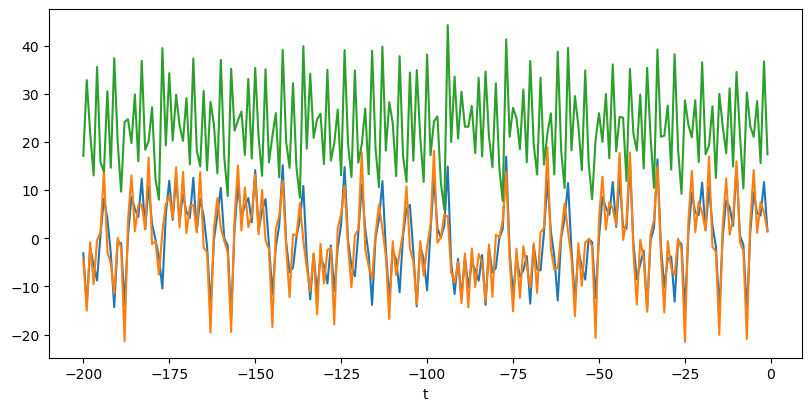

In [22]:
fig = Figure(figsize=(8, 4), dpi=100, constrained_layout=1)
ax = fig.gca()
ax.plot(np.arange(-200, 0), x_pred[-200:])
ax.set_xlabel("t")
fig

# Uncertainty propagation of $F(\mathcal N(x_0, Q))$

In [23]:
x_0 = Normal(x_train[0], Q)

In [24]:
input_samples = x_0.qmc(2**10)

In [25]:
output_samples = jax.vmap(network)(input_samples)

In [26]:
output_unscented = network(x_0, method="unscented")
output_linear = network(x_0, method="linear")
output_analytic = network(x_0, method="analytic")

In [27]:
output_mc = Normal(
    np.mean(output_samples, axis=0), np.cov(output_samples, rowvar=False)
)

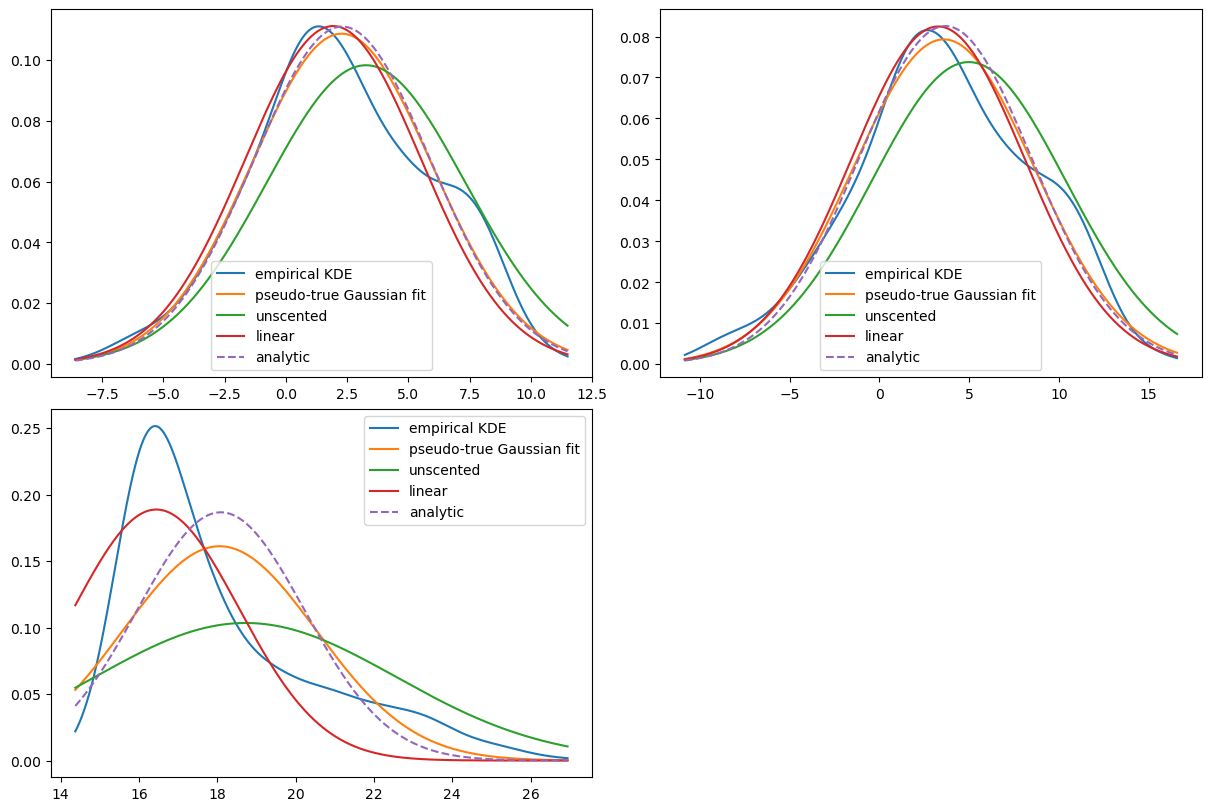

In [28]:
fig = Figure(figsize=(12, 8), dpi=100, constrained_layout=1)
for i in range(3):
    ax = fig.add_subplot(2, 2, i + 1)
    grid = np.linspace(np.min(output_samples[:, i]), np.max(output_samples[:, i]), 2000)
    ax.plot(
        grid,
        scipy.stats.gaussian_kde(output_samples[:, i].reshape(-1))(grid),
        label="empirical KDE",
    )
    for label, dist, linestyle in (
        ("pseudo-true Gaussian fit", output_mc, "-"),
        ("unscented", output_unscented, "-"),
        ("linear", output_linear, "-"),
        ("analytic", output_analytic, "--"),
    ):
        ax.plot(
            grid,
            dist[i].pdf(grid),
            label=label,
            linestyle=linestyle,
        )
    ax.legend()

fig

# Kalman filter example
## Generate data

In [29]:
n_x = 3
n_u = 0
n_y = 1

F = network
H = ProbitLinearNetwork(
    ProbitLinear.create_linear(
        in_size=n_x + n_u,
        out_size=n_y,
        C=np.eye(n_x)[(0,), :],
        d=np.zeros((n_y)),
    )
)
H_aug = H.augment_with_identity()

In [30]:
sim_horizon = 2000
R = jnp.eye(n_y) * 1e-2

In [31]:
process_noise_keys = jax.random.split(jax.random.PRNGKey(122), sim_horizon)

In [32]:
with jax.default_device(jax.devices("cpu")[0]):
    ϵ = jax.random.multivariate_normal(
        mean=jnp.zeros(n_y), cov=R, key=jax.random.PRNGKey(300), shape=sim_horizon
    )

In [33]:
x = np.ones((sim_horizon, n_x))
x[0] = [-8.0, 4.0, 27.0]
y = np.zeros((sim_horizon, n_y))
y_noiseless = np.zeros((sim_horizon, n_y))
for i in trange(1, sim_horizon):
    x[i, :] = F_true(x[i - 1, :], process_noise_keys[i - 1], **lorenz_args)
    y_noiseless[i, :] = H(x[i, :])
    y[i, :] = y_noiseless[i, :] + ϵ[i]

  0%|          | 0/1999 [00:00<?, ?it/s]

Actual state and output trajectory

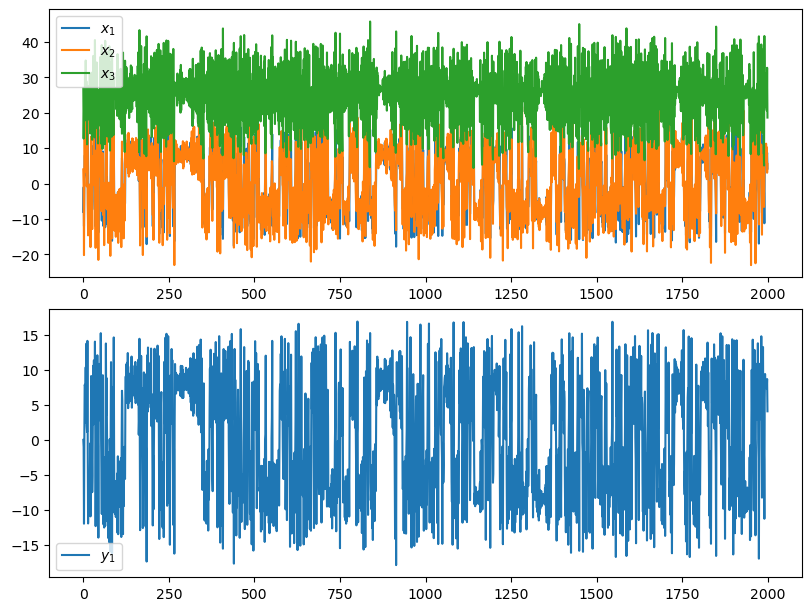

In [34]:
fig = Figure(figsize=(8, 6), dpi=100, constrained_layout=1)
ax = fig.add_subplot(211)
for i in range(n_x):
    ax.plot(x[:, i], label=rf"$x_{i+1}$")
ax.legend()
ax = fig.add_subplot(212)
for i in range(n_y):
    ax.plot(y[:, i], label=rf"$y_{i+1}$")
ax.legend()
fig

## Filtering

In [35]:
method = "analytic"
# method = "linear"
# method = "unscented"

recalibrate = True
rectify = True

In [36]:
importlib.reload(neural_kalman)

<module 'neural_kalman' from '/home/simon/Documents/School/Research/neural-network-kalman/src/neural_kalman.py'>

In [37]:
kalman = neural_kalman.NeuralKalmanFilter(n_x=n_x, n_u=n_u, n_y=n_y, F=F, H=H, Q=Q, R=R)

In [38]:
x_0 = Normal(x[0], Q)
x_pred = [x_0]
x_post = [x_0]

In [39]:
for i in trange(1, sim_horizon):
    x_and_y_pred = kalman.predict(x_post[i - 1], method=method, rectify=rectify)
    x_pred.append(x_and_y_pred[kalman.STATES])
    x_post.append(
        kalman.correct(x_and_y_pred, y[i], recalibrate=recalibrate, rectify=rectify)
    )

  0%|          | 0/1999 [00:00<?, ?it/s]

In [40]:
x_smooth = list(x_post)
for i in trange(sim_horizon - 2, -1, -1):
    x_smooth[i] = kalman.smooth(
        x_smooth[i], x_smooth[i + 1], method=method, rectify=rectify
    )

  0%|          | 0/1999 [00:00<?, ?it/s]

In [41]:
diagnostics = kalman_diagnostics.KalmanDiagnostics(kalman, x)

In [42]:
print(f"{'rms(predicted x - true x)':<25}", diagnostics.point_rmse(x_pred))
print(f"{'rms(filtered x - true x)':<25}", diagnostics.point_rmse(x_post))
print(f"{'rms(smooth x - true x)':<25}", diagnostics.point_rmse(x_smooth))

rms(predicted x - true x) 2.557089212935381
rms(filtered x - true x)  1.2787119368016389
rms(smooth x - true x)    0.9934363170735545


In [43]:
time_slice = slice(sim_horizon // 2 - 50, sim_horizon // 2 + 50)

Plot the actual states under the 90% prediction interval. Expect 10 misses in this time segment.

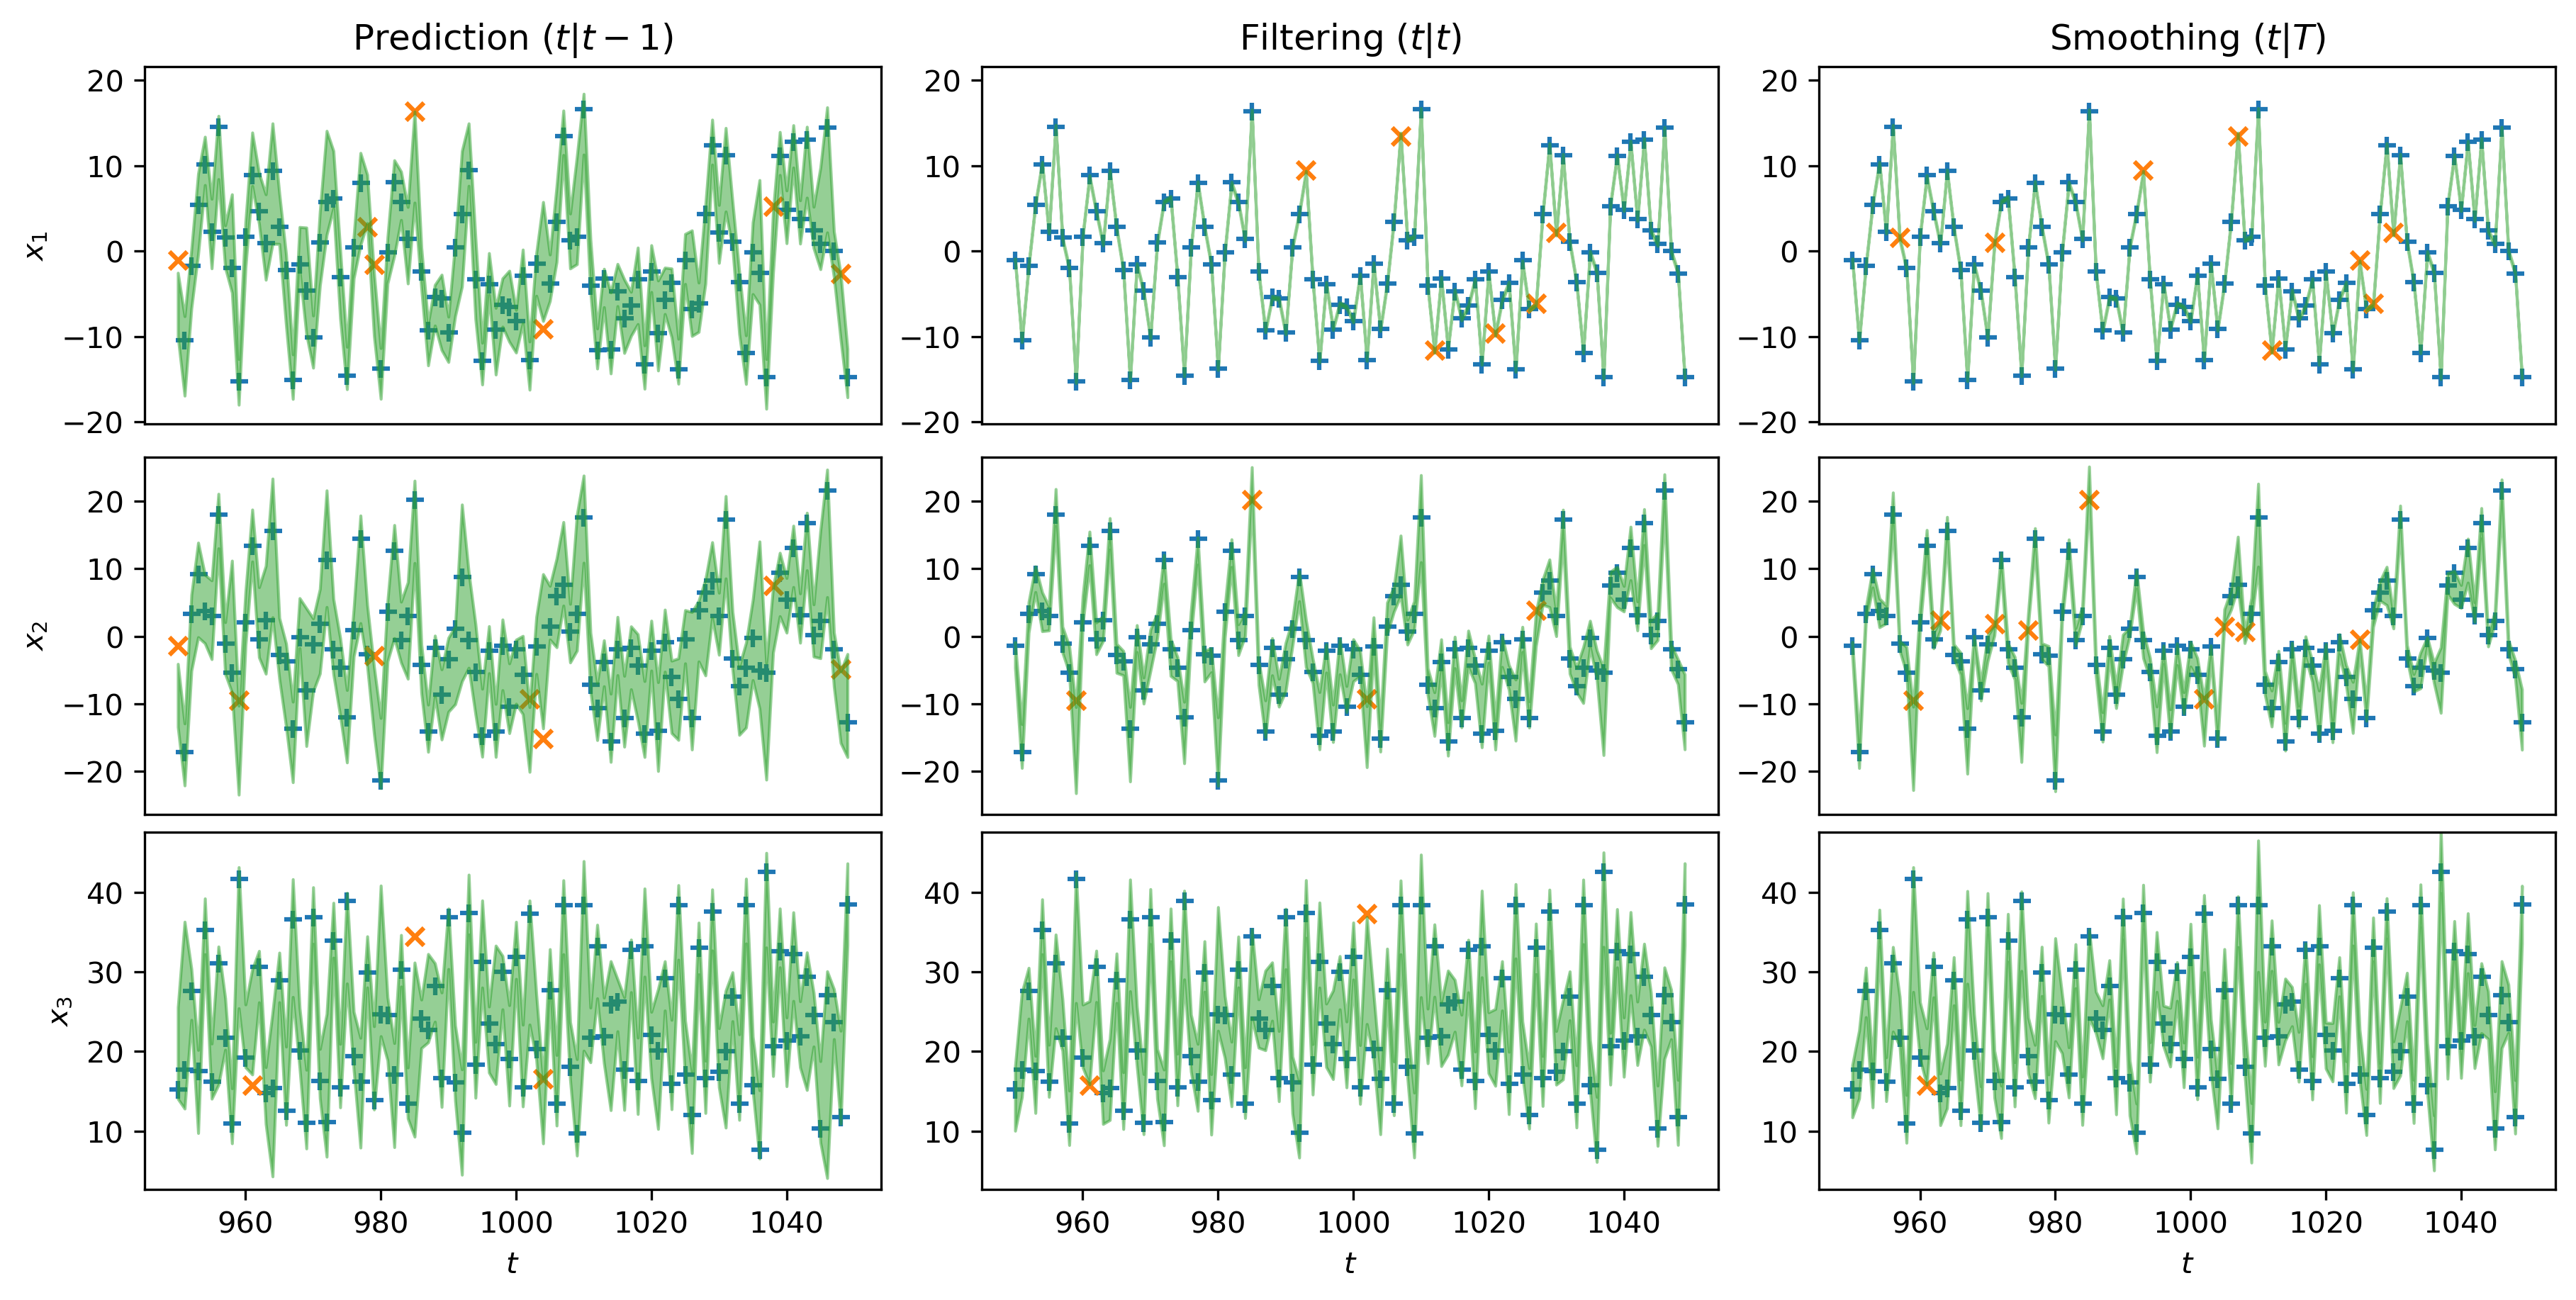

In [44]:
fig = Figure(figsize=(12, 6), dpi=300, constrained_layout=1)
for i in range(n_x):
    for j, (x_trajectory, desc) in enumerate(
        [
            (x_pred, "Prediction $(t|t-1)$"),
            (x_post, "Filtering $(t|t)$"),
            (x_smooth, "Smoothing $(t|T)$"),
        ]
    ):
        # prepare and decorate axes
        ax = fig.add_subplot(3, 3, 3 * i + j + 1)
        if j == 0:
            ax.set_ylabel(rf"$x_{i+1}$")
        else:
            pass  # ax.set_yticks([])
        if i == 0:
            ax.set_title(desc)
        if i == 2:
            ax.set_xlabel(rf"$t$")
        else:
            ax.set_xticks([])
        # get data to plot
        times, state, _mean, lower, upper, covered, missed = (
            diagnostics.plot_state_trajectories(
                x_trajectory, i, time_slice, coverage=0.90
            )
        )
        # plot data
        ax.set_ylim(min(state) - 5, max(state) + 5)
        ax.scatter(
            times[covered],
            state[covered],
            color="C0",
            marker="+",
        )
        ax.scatter(
            times[missed],
            state[missed],
            color="C1",
            marker="x",
        )
        ax.fill_between(
            times,
            lower,
            upper,
            color="C2",
            alpha=0.5,
        )
fig

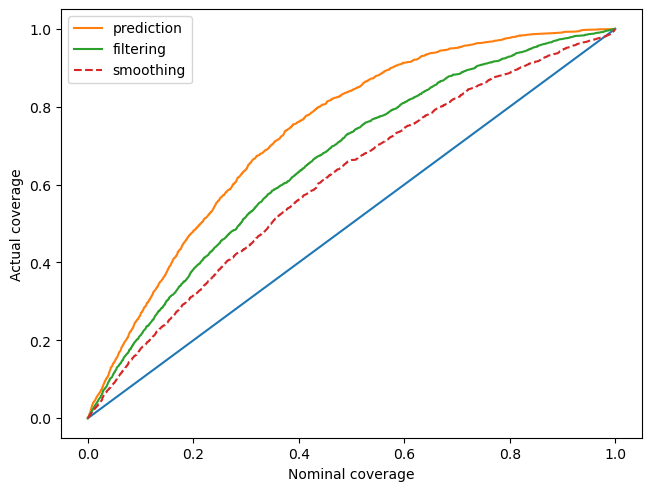

In [45]:
fig = Figure(dpi=100, constrained_layout=1)
ax = fig.add_subplot()
ax.plot([0, 1], [0, 1])
ax.plot(*diagnostics.calculate_coverage(x_pred), label="prediction")
ax.plot(*diagnostics.calculate_coverage(x_post), label="filtering")
ax.plot(*diagnostics.calculate_coverage(x_smooth), label="smoothing", linestyle="--")
ax.set_xlabel("Nominal coverage")
ax.set_ylabel("Actual coverage")
ax.legend()
# fig.savefig(f"/tmp/coverage-{method}.jpg")
# fig.savefig(f"figures/kalman/coverage-{method}.pdf")
fig

# Performance analysis: I/Os and flops
## predict

In [46]:
print(f"{'Method':<10} {'I/Os':>10} {'FLOPs':>10}")
for method in ["analytic", "linear", "unscented"]:
    cost_analysis = (
        jax.jit(functools.partial(kalman.predict, method=method))
        .trace(x_post[0])
        .lower()
        .compile()
        .cost_analysis()
    )

    print(
        f"{method:<10} {cost_analysis['bytes accessed']:>10} {cost_analysis['flops']:>10}"
    )

Method           I/Os      FLOPs
analytic   15341086.0 25269848.0
linear      3221686.0 14943866.0
unscented    469652.0   784107.0


## update

In [47]:
print(f"{'Method':<10} {"Recalibrate":<10} {'I/Os':>10} {'FLOPs':>10}")
for recalibrate in [True, False]:
    for method in ["analytic", "linear", "unscented"] if recalibrate else ["all"]:
        cost_analysis = (
            jax.jit(
                functools.partial(
                    kalman.correct, recalibrate_method=method, recalibrate=recalibrate
                )
            )
            .trace(
                x_and_y_pred,
                y[0],
            )
            .lower()
            .compile()
            .cost_analysis()
        )
        print(
            f"{method:<10} {str(recalibrate):<10} {cost_analysis['bytes accessed']:>10} {cost_analysis['flops']:>10}"
        )

Method     Recalibrate       I/Os      FLOPs
analytic   True          10896.0     3608.0
linear     True           4488.0     1288.0
unscented  True           9595.0     4839.0
all        False           393.0       24.0


## smooth

In [48]:
print(f"{'Method':<10} {'I/Os':>10} {'FLOPs':>10}")
for method in ["analytic", "linear", "unscented"]:
    cost_analysis = (
        jax.jit(functools.partial(kalman.smooth, method=method))
        .trace(x_smooth[0], x_smooth[1])
        .lower()
        .compile()
        .cost_analysis()
    )
    print(
        f"{method:<10} {cost_analysis['bytes accessed']:>10} {cost_analysis['flops']:>10}"
    )

Method           I/Os      FLOPs
analytic   16309000.0 27591520.0
linear      3447040.0 16380598.0
unscented    499283.0   833194.0
